In [1]:
import sys, os, json, shap, gc, joblib, time, warnings, copy, ast
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc
import matplotlib.pyplot as plt
from rdsutils.woe import WOE_Transform, get_monotone_dir 
from rdsutils.feature_selection import mrmr
from rdsutils.metrics import get_pred_reports
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult

warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

sys.path.insert(1, "./")
from utility.performance_eval_plot import score_gain, plot_efficient_frontier, plot_percentile_bad_rate
import utility.performance_eval_v3 as p_eval
from utility  import data_summary, woe, data_eda, psi

%load_ext autoreload
%autoreload 2

print(lgb.__version__)

3.2.1


### read data

In [2]:
df = pd.read_parquet('./artifact/df_gen4_score_oot.parquet')

In [3]:
list(df)

['id',
 'applicant_type',
 'date_start',
 'seg',
 'ri_source',
 'target_v2',
 'weight_eval',
 'gen4_prescreen_score',
 'gen4_prescreen_prob',
 'period',
 'gen4_underwriting_prob',
 'gen4_underwriting_score',
 'gen3_score',
 'fico_adj',
 'applicant_vantage_score',
 'funds_use_encode_v2',
 'income_update']

In [4]:
df["pred_fico"] = -df["fico_adj"]  # reverse dir of fico score
df["pred_gen3"] = -df["gen3_score"]  # reverse dir of gen3 score

In [5]:
df[['ri_source']].value_counts()

ri_source
others       968346
proxy        111313
booked        71066
dtype: int64

### overall

In [6]:
pred_cols = ['pred_fico',
             'pred_gen3',
             'gen4_prescreen_prob',
             'gen4_underwriting_prob']


print(f"--------TTD --------")
test_df_ = df.copy()
print(test_df_.shape)

perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
display(perf.round(4))


print(f"--------booked --------")
test_df_ = df[(df.ri_source=='booked')].copy()
print(test_df_.shape)

perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
display(perf.round(4))

--------TTD --------
(1150725, 19)


,auc,ap,ks,ks_chg
pred_fico,0.7252,0.3237,32.89,0.8750
pred_gen3,0.7546,0.3487,37.59,1.0000
gen4_prescreen_prob,0.7664,0.3647,39.36,1.0471
gen4_underwriting_prob,0.7727,0.3697,40.54,1.0785


--------booked --------
(71066, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6161,0.0738,16.90,0.5656
pred_gen3,0.7023,0.1148,29.88,1.0000
gen4_prescreen_prob,0.7295,0.1263,33.25,1.1128
gen4_underwriting_prob,0.7367,0.1349,34.68,1.1606


### by RI source: funded, proxy, others

In [7]:
pred_cols = ['pred_fico',
             'pred_gen3',
             'gen4_prescreen_prob',
             'gen4_underwriting_prob']
for p in ['proxy', 'others']:
    print(f"--------OOT - {p} --------")
    test_df_ = df[df.ri_source ==p].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

--------OOT - proxy --------
(111313, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6418,0.1620,20.49,0.7222
pred_gen3,0.6950,0.1928,28.37,1.0000
gen4_prescreen_prob,0.7113,0.2068,30.49,1.0747
gen4_underwriting_prob,0.7192,0.2157,32.46,1.1442


--------OOT - others --------
(968346, 19)


,auc,ap,ks,ks_chg
pred_fico,0.7170,0.3468,31.73,0.8789
pred_gen3,0.7446,0.3714,36.10,1.0000
gen4_prescreen_prob,0.7566,0.3879,37.96,1.0515
gen4_underwriting_prob,0.7627,0.3924,39.06,1.0820


### by period (OOT1 and OOT2)

In [8]:
for p in ['oot18q1', 'oot19q2']:
    print(f"--------TTD - period oot - {p} --------")
    test_df_ = df[df.period ==p].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))


for p in ['oot18q1', 'oot19q2']:
    print(f"--------booked - period oot - {p} --------")
    test_df_ = df[(df.ri_source=='booked') & (df.period ==p)].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

--------TTD - period oot - oot18q1 --------
(567316, 19)


,auc,ap,ks,ks_chg
pred_fico,0.7129,0.3122,30.93,0.8613
pred_gen3,0.7430,0.3368,35.91,1.0000
gen4_prescreen_prob,0.7561,0.3544,37.76,1.0515
gen4_underwriting_prob,0.7630,0.3617,39.04,1.0872


--------TTD - period oot - oot19q2 --------
(583409, 19)


,auc,ap,ks,ks_chg
pred_fico,0.7380,0.3401,35.05,0.8887
pred_gen3,0.7668,0.3622,39.44,1.0000
gen4_prescreen_prob,0.7772,0.3771,41.06,1.0411
gen4_underwriting_prob,0.7826,0.3798,42.17,1.0692


--------booked - period oot - oot18q1 --------
(38086, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6257,0.0830,18.55,0.6072
pred_gen3,0.7051,0.1257,30.55,1.0000
gen4_prescreen_prob,0.7277,0.1360,32.81,1.0740
gen4_underwriting_prob,0.7341,0.1444,34.31,1.1231


--------booked - period oot - oot19q2 --------
(32980, 19)


,auc,ap,ks,ks_chg
pred_fico,0.5904,0.0583,13.57,0.4771
pred_gen3,0.6909,0.0966,28.44,1.0000
gen4_prescreen_prob,0.7257,0.1103,32.89,1.1565
gen4_underwriting_prob,0.7343,0.1192,34.98,1.2300


### by segment (Member/non-Member)

In [9]:
pred_cols = ['pred_fico',
             'pred_gen3',
             'gen4_underwriting_prob']


for p in ['member', 'non_member']:
    print(f"--------TTD - seg - {p} --------")
    test_df_ = df[df.seg ==p].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))


for p in ['member', 'non_member']:
    print(f"--------booked - seg - {p} --------")
    test_df_ = df[(df.ri_source=='booked') & (df.seg ==p)].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

--------TTD - seg - member --------
(99951, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6815,0.1381,26.29,0.7676
pred_gen3,0.7332,0.1716,34.25,1.0000
gen4_underwriting_prob,0.7688,0.2078,40.06,1.1696


--------TTD - seg - non_member --------
(1050774, 19)


,auc,ap,ks,ks_chg
pred_fico,0.7203,0.3303,32.24,0.8751
pred_gen3,0.7498,0.3551,36.84,1.0000
gen4_underwriting_prob,0.7670,0.3757,39.71,1.0779


--------booked - seg - member --------
(15799, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6299,0.0627,19.75,0.5720
pred_gen3,0.7205,0.1044,34.53,1.0000
gen4_underwriting_prob,0.7536,0.1231,37.32,1.0808


--------booked - seg - non_member --------
(55267, 19)


,auc,ap,ks,ks_chg
pred_fico,0.6089,0.0762,15.69,0.5403
pred_gen3,0.6987,0.1187,29.04,1.0000
gen4_underwriting_prob,0.7304,0.1400,33.81,1.1643


### by FICO Band

In [10]:
df['fico_bin'] = 'other'
df.loc[df.fico_adj>=720, 'fico_bin'] = 'super_prime'
df.loc[(df.fico_adj<720) & (df.fico_adj>=660), 'fico_bin'] = 'prime'
df.loc[(df.fico_adj<660) & (df.fico_adj>=620), 'fico_bin'] = 'near_prime'
df.loc[(df.fico_adj<620), 'fico_bin'] = 'sub_prime'

In [11]:
pred_cols = ['pred_fico',
             'pred_gen3',
             'gen4_prescreen_prob',
             'gen4_underwriting_prob']

for p in ['super_prime', 'prime','near_prime','sub_prime']:
    print(f"--------TTD - oot - {p} --------")
    test_df_ = df[df.fico_bin ==p].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

--------TTD - oot - super_prime --------
(390219, 20)


,auc,ap,ks,ks_chg
pred_fico,0.6004,0.0775,15.05,0.5054
pred_gen3,0.7028,0.1391,29.78,1.0000
gen4_prescreen_prob,0.7316,0.1549,34.16,1.1471
gen4_underwriting_prob,0.7407,0.1628,35.51,1.1924


--------TTD - oot - prime --------
(383489, 20)


,auc,ap,ks,ks_chg
pred_fico,0.5585,0.1488,8.94,0.4304
pred_gen3,0.6457,0.2113,20.77,1.0000
gen4_prescreen_prob,0.6726,0.2291,24.76,1.1921
gen4_underwriting_prob,0.6873,0.2415,27.17,1.3081


--------TTD - oot - near_prime --------
(154742, 20)


,auc,ap,ks,ks_chg
pred_fico,0.5361,0.2206,5.67,0.3196
pred_gen3,0.6243,0.2934,17.74,1.0000
gen4_prescreen_prob,0.6468,0.3138,21.21,1.1956
gen4_underwriting_prob,0.6603,0.3250,23.31,1.3140


--------TTD - oot - sub_prime --------
(222275, 20)


,auc,ap,ks,ks_chg
pred_fico,0.5985,0.4319,14.73,0.7945
pred_gen3,0.6250,0.4517,18.54,1.0000
gen4_prescreen_prob,0.6450,0.4725,21.57,1.1634
gen4_underwriting_prob,0.6493,0.4744,22.25,1.2001


### by Loan Purpose
- 1: CC pay off
- 2: Debt Consolidation
- 3: Home Improvement
- 4: Major Purchase
- 5: Others

In [23]:
for p in [1,2,3,4,5]:
    print(f"--------TTD - oot - {p} --------")
    test_df_ = df[df.funds_use_encode_v2 ==p].copy()
    print(test_df_.shape)

    perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                                sample_weight_col="weight_eval").sort_values("ks")
    perf["ks_chg"] = perf["ks"] / perf.loc["pred_gen3", "ks"]
    display(perf.round(4))

--------TTD - oot - 1 --------
(554645, 20)


,auc,ap,ks,ks_chg
pred_fico,0.7067,0.2605,29.80,0.8696
pred_gen3,0.7348,0.2854,34.27,1.0000
gen4_prescreen_prob,0.7494,0.3010,36.48,1.0645
gen4_underwriting_prob,0.7580,0.3090,37.85,1.1045


--------TTD - oot - 2 --------
(270962, 20)


,auc,ap,ks,ks_chg
pred_fico,0.7032,0.2999,29.42,0.8694
pred_gen3,0.7315,0.3258,33.84,1.0000
gen4_prescreen_prob,0.7449,0.3405,35.91,1.0612
gen4_underwriting_prob,0.7508,0.3453,37.01,1.0937


--------TTD - oot - 3 --------
(82358, 20)


,auc,ap,ks,ks_chg
pred_fico,0.7651,0.3143,39.18,0.8838
pred_gen3,0.7956,0.3442,44.33,1.0000
gen4_prescreen_prob,0.8045,0.3546,45.72,1.0314
gen4_underwriting_prob,0.8078,0.3588,46.76,1.0548


--------TTD - oot - 4 --------
(61745, 20)


,auc,ap,ks,ks_chg
pred_fico,0.7390,0.3625,35.11,0.8891
pred_gen3,0.7649,0.3916,39.49,1.0000
gen4_prescreen_prob,0.7739,0.4039,40.52,1.0261
gen4_underwriting_prob,0.7787,0.4060,41.70,1.0560


--------TTD - oot - 5 --------
(181015, 20)


,auc,ap,ks,ks_chg
pred_fico,0.7373,0.4261,36.25,0.9255
pred_gen3,0.7536,0.4425,39.17,1.0000
gen4_prescreen_prob,0.7630,0.4582,40.06,1.0227
gen4_underwriting_prob,0.7677,0.4612,40.97,1.0460


### plot Efficient Frontier, Bad Rate by Percentile, ROC on TTD and Funded

In [13]:
local_artifact_path = "./artifact/"

    pct_cum_acct   #accts       min       max  target_num  pct_cum_target  pct_cum_nontarget  actual_rate       KS  cum_bads  cum_acct
0       0.044455  28170.5  0.484445  0.940281     14220.5        0.149095           0.025915     0.504801  12.3180  0.010288  0.055248
1       0.089497  28542.0  0.385298  0.484444     11721.1        0.271986           0.057163     0.410661  21.4823  0.015358  0.109773
2       0.135363  29065.0  0.319165  0.385297      9802.7        0.374762           0.092946     0.337268  28.1816  0.019800  0.163813
3       0.181839  29450.5  0.269814  0.319164      8331.3        0.462112           0.132179     0.282892  32.9933  0.024198  0.217248
4       0.228988  29878.0  0.231321  0.269812      7317.2        0.538829           0.174090     0.244903  36.4739  0.029132  0.270055
5       0.276737  30257.5  0.200327  0.231319      6403.3        0.605965           0.218403     0.211627  38.7562  0.033630  0.322567
6       0.324922  30534.0  0.175057  0.200324      5634

No handles with labels found to put in legend.


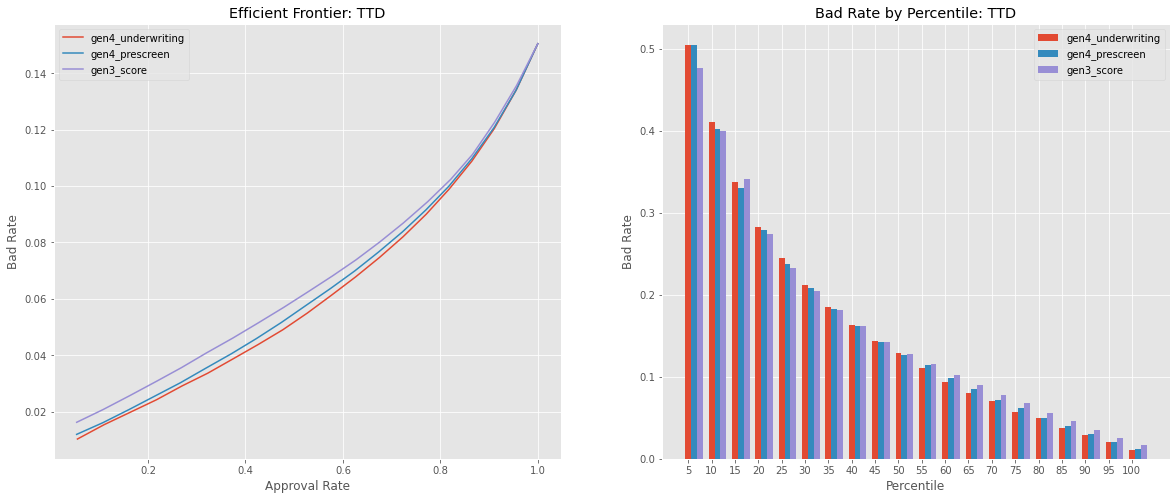

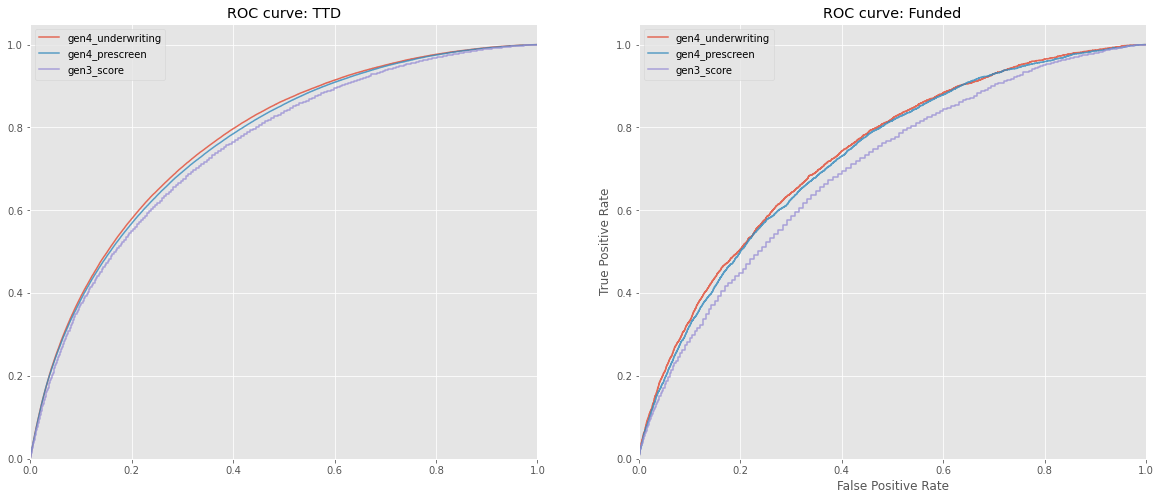

In [14]:
target = 'target_v2'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df.copy()
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = df[(df.ri_source=="booked")]
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]
title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()
plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_.png"))

    pct_cum_acct   #accts       min       max  target_num  pct_cum_target  pct_cum_nontarget  actual_rate       KS  cum_bads  cum_acct
0       0.043843  14308.0  0.489505  0.940281      6980.3        0.137071           0.026606     0.487860  11.0465  0.012466  0.056069
1       0.088428  14550.0  0.391543  0.489498      5923.7        0.253394           0.057926     0.407127  19.5468  0.018277  0.111220
2       0.133794  14805.0  0.325055  0.391530      5150.8        0.354539           0.092979     0.347909  26.1560  0.022942  0.165757
3       0.179957  15065.0  0.275374  0.325046      4424.4        0.441420           0.131613     0.293687  30.9807  0.028150  0.219479
4       0.226858  15306.0  0.236959  0.275366      3923.4        0.518464           0.172941     0.256331  34.5523  0.033012  0.272610
5       0.274286  15478.0  0.206470  0.236955      3451.5        0.586240           0.216607     0.222994  36.9633  0.038236  0.325288
6       0.322300  15669.0  0.181278  0.206467      3039

No handles with labels found to put in legend.


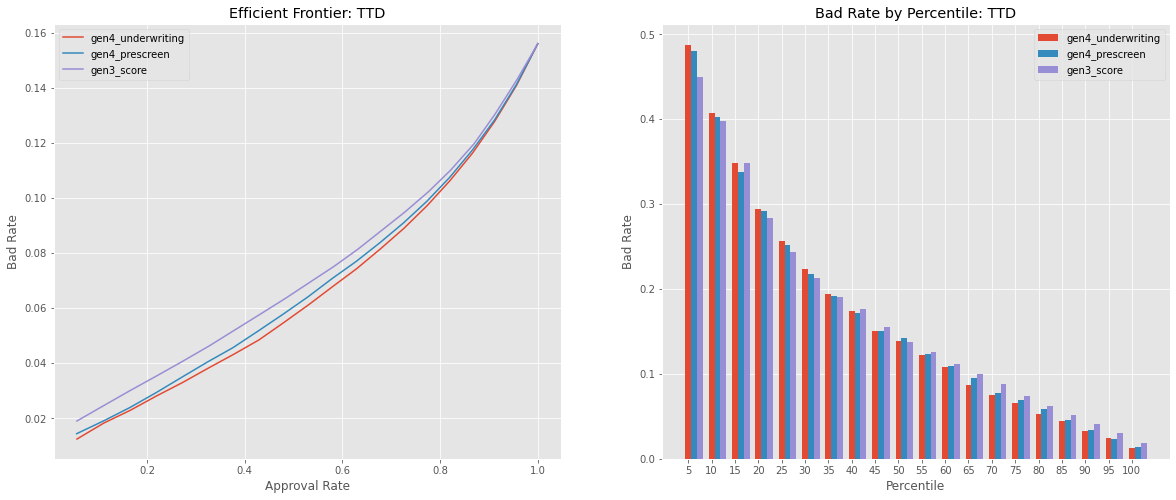

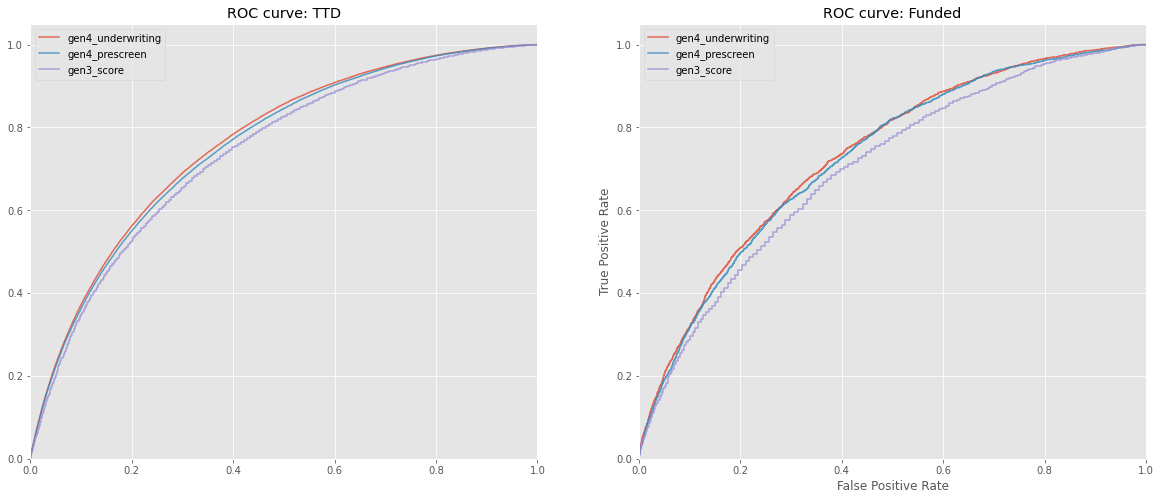

In [15]:
target = 'target_v2'
p = 'oot18q1'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.period ==p].copy()
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = df[(df.ri_source=="booked") & (df.period ==p)]
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]
title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()
plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_.png"))

    pct_cum_acct   #accts       min       max  target_num  pct_cum_target  pct_cum_nontarget  actual_rate       KS  cum_bads  cum_acct
0       0.044990  13827.0  0.478899  0.864978      7254.2        0.163184           0.025003     0.524640  13.8181  0.008932  0.055406
1       0.090386  13952.0  0.379426  0.478883      5751.3        0.292560           0.056198     0.412220  23.6362  0.013091  0.109929
2       0.136644  14217.0  0.313276  0.379418      4637.5        0.396880           0.092638     0.326194  30.4242  0.016935  0.163712
3       0.183332  14349.0  0.264367  0.313271      3921.3        0.485090           0.132304     0.273280  35.2786  0.021200  0.217035
4       0.230591  14524.5  0.225661  0.264367      3327.8        0.559949           0.174896     0.229116  38.5053  0.025564  0.269802
5       0.278356  14680.0  0.194094  0.225660      2945.7        0.626213           0.219533     0.200661  40.6680  0.029780  0.321934
6       0.326541  14809.0  0.168582  0.194093      2552

No handles with labels found to put in legend.


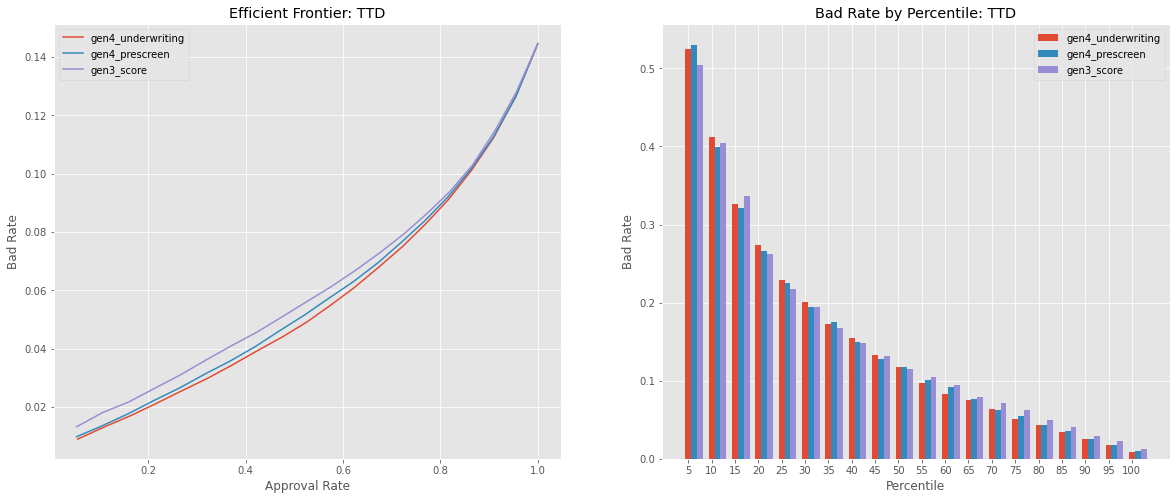

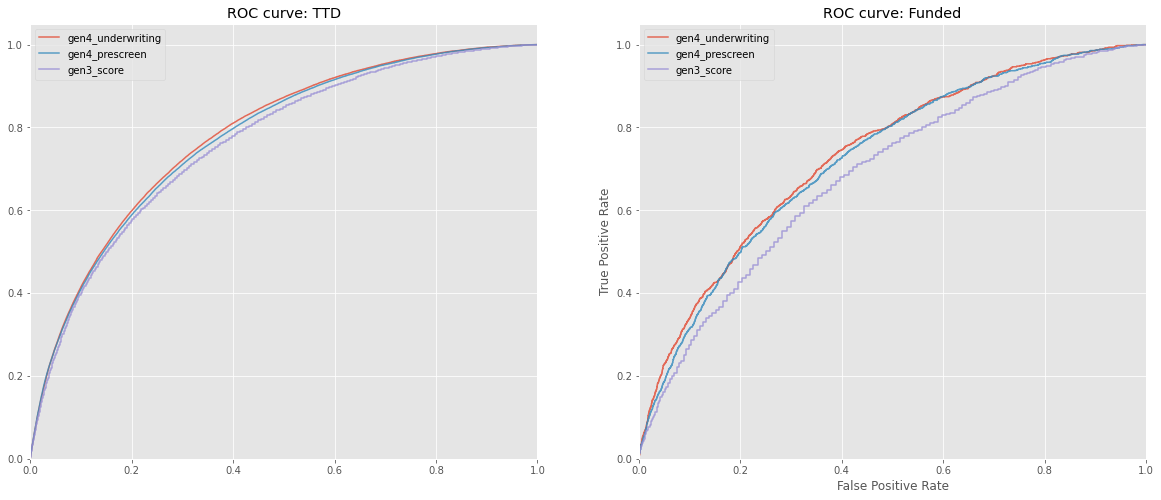

In [16]:
target = 'target_v2'
p = 'oot19q2'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.period ==p].copy()
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = df[(df.ri_source=="booked") & (df.period ==p)]
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['gen4_prescreen_prob'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'gen3_score')
]
title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()
plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_.png"))

    pct_cum_acct  #accts       min       max  target_num  pct_cum_target  pct_cum_nontarget  actual_rate       KS  cum_bads  cum_acct
0       0.044419  2728.0  0.244914  0.720141       771.8        0.179999           0.034243     0.282918  14.5756  0.004959  0.049906
1       0.090385  2823.0  0.181520  0.244897       545.7        0.307267           0.074107     0.193305  23.3160  0.006063  0.101783
2       0.137589  2899.0  0.145455  0.181477       430.7        0.407715           0.117314     0.148568  29.0401  0.008028  0.153537
3       0.185069  2916.0  0.120895  0.145442       404.5        0.502052           0.161277     0.138717  34.0775  0.008800  0.205764
4       0.233844  2995.5  0.101892  0.120882       356.6        0.585219           0.207470     0.119045  37.7749  0.010525  0.258040
5       0.283196  3031.0  0.086626  0.101888       270.7        0.648351           0.255789     0.089310  39.2562  0.012450  0.309696
6       0.332476  3026.5  0.074477  0.086625       229.1      

No handles with labels found to put in legend.


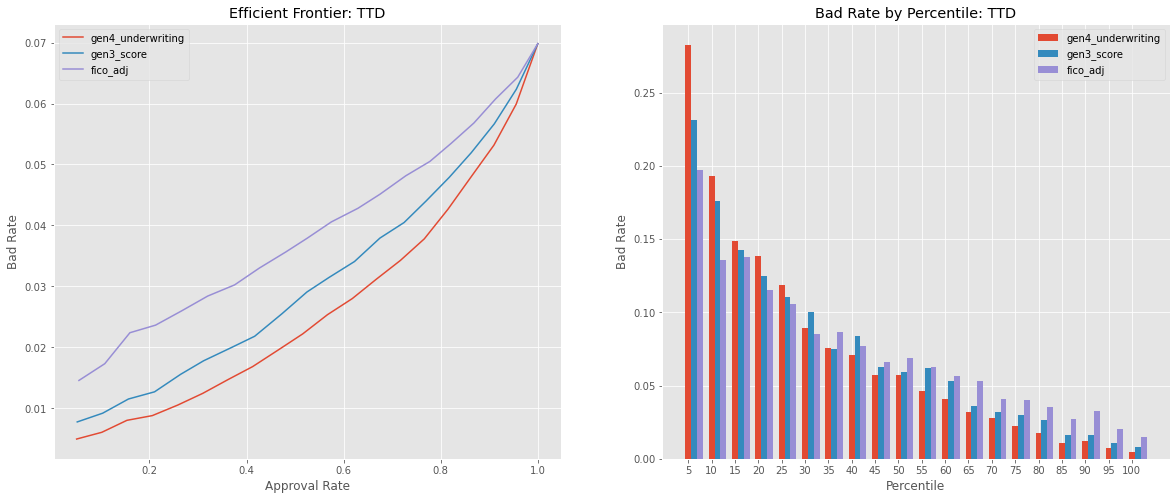

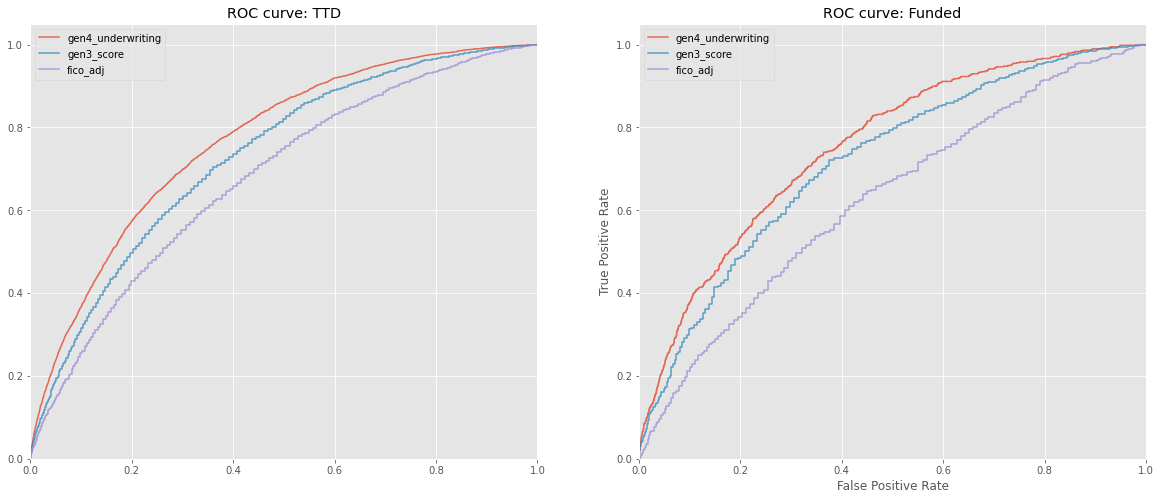

In [17]:
seg = "member"
target = 'target_v2'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.seg == seg]
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_{seg}.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.seg == seg]

preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = df[(df.ri_source=="booked")
             & (df.seg==seg)]

preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]


title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()
plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_{seg}.png"))

    pct_cum_acct   #accts       min       max  target_num  pct_cum_target  pct_cum_nontarget  actual_rate       KS  cum_bads  cum_acct
0       0.044927  25710.0  0.492889  0.940281     13100.9        0.143822           0.026205     0.509564  11.7617  0.012328  0.054701
1       0.090332  25984.0  0.398631  0.492886     10977.9        0.264338           0.057391     0.422487  20.6947  0.018191  0.108645
2       0.136506  26424.0  0.332186  0.398628      9219.0        0.365545           0.093147     0.348887  27.2398  0.022796  0.162392
3       0.183222  26734.0  0.282786  0.332185      7923.7        0.452532           0.132239     0.296390  32.0293  0.027851  0.215528
4       0.230552  27085.5  0.243742  0.282782      6952.7        0.528859           0.174080     0.256695  35.4779  0.032822  0.268189
5       0.278481  27428.5  0.211821  0.243739      6130.9        0.596164           0.218341     0.223523  37.7823  0.037946  0.320461
6       0.326869  27690.5  0.185613  0.211818      5466

No handles with labels found to put in legend.


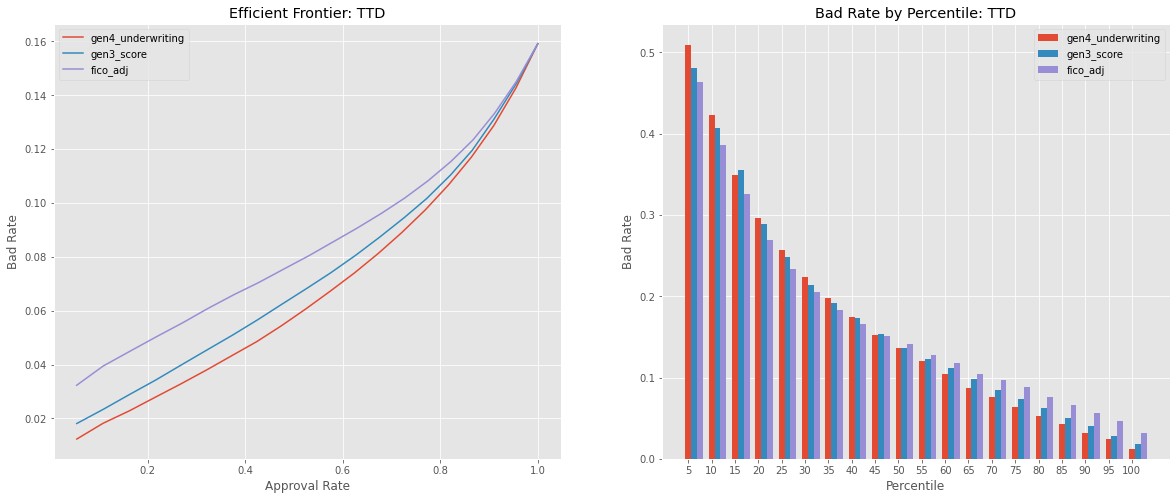

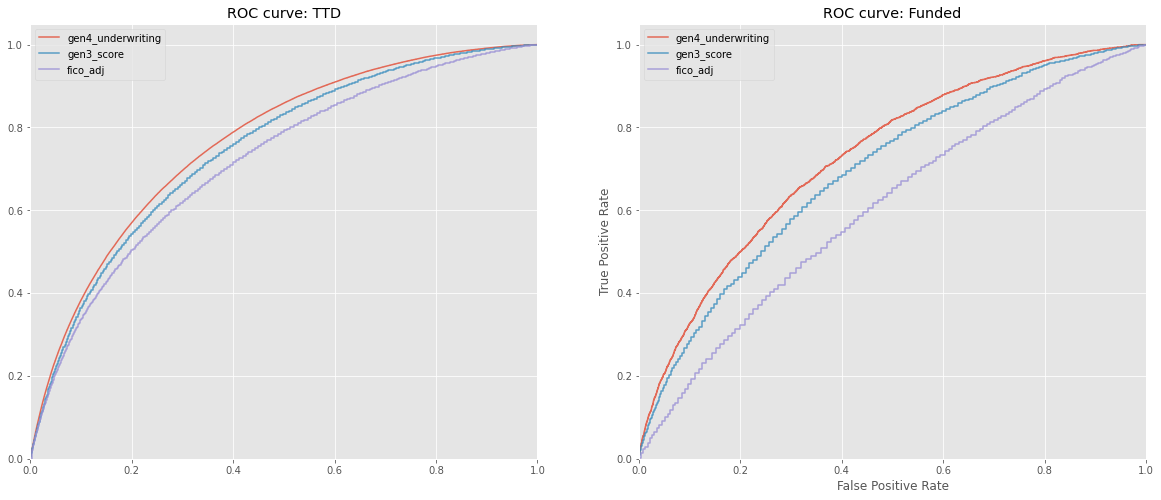

In [18]:
seg = "non_member"
target = 'target_v2'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.seg == seg]
preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_{seg}.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = df[df.seg == seg]

preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = df[(df.ri_source=="booked")
             & (df.seg==seg)]

preds = [
    (df_['gen4_underwriting_prob'], 'gen4_underwriting'),
    (df_['pred_gen3'], 'gen3_score'),
    (df_['pred_fico'], 'fico_adj')
]


title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()
plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_{seg}.png"))

### gains table

gen4_prescreen_prob AUC:  0.75609  KS:  37.7

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.4%  14295.0  0.4931  0.9123      6864.2          13.5%              2.7%       48.0%  10.8
1          8.8%  14552.0  0.3824  0.4931      5861.4          25.0%              5.9%       40.3%  19.1
2         13.4%  14837.0  0.3127  0.3824      5009.1          34.8%              9.4%       33.8%  25.4
3         18.0%  15105.0  0.2643  0.3127      4410.5          43.5%             13.3%       29.2%  30.2
4         22.7%  15349.0  0.2271  0.2643      3859.5          51.1%             17.5%       25.1%  33.6
5         27.5%  15546.0  0.1983  0.2271      3385.7          57.7%             21.9%       21.8%  35.8
6         32.3%  15779.0  0.1750  0.1983      3024.3          63.7%             26.5%       19.2%  37.2
7         37.2%  15904.0  0.1553  0.1750      2731.4          69.0%             31.3%       17.2%  37.

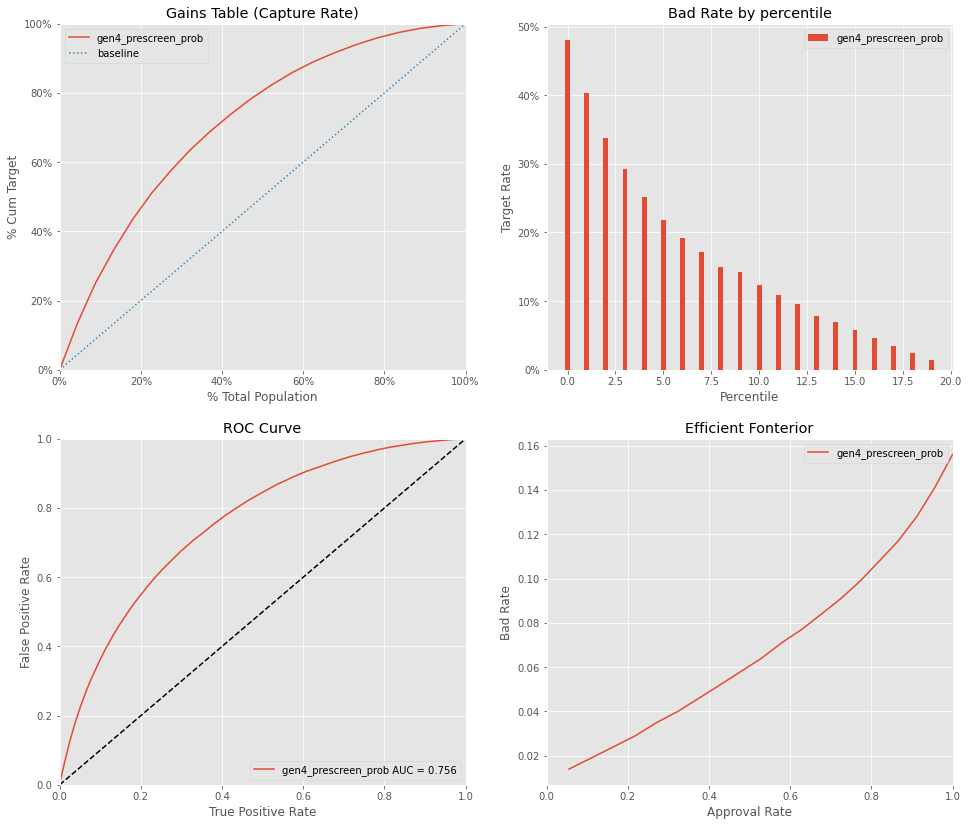

(0.7560902015848823, 37.699999999999996)

In [19]:
p_eval.model_score_eval(df[df.period=='oot18q1']['target_v2'],
                        df[df.period=='oot18q1']['gen4_prescreen_prob'],
                        Y_weight=df[df.period=='oot18q1']['weight_eval'],decile=20)

gen4_prescreen_prob AUC:  0.77721  KS:  41.0

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.5%  13856.0  0.4851  0.8950      7348.5          16.5%              2.5%       53.0%  14.0
1          9.1%  14024.5  0.3756  0.4851      5592.4          29.1%              5.7%       39.9%  23.4
2         13.7%  14258.5  0.3067  0.3756      4570.6          39.4%              9.4%       32.1%  30.0
3         18.4%  14400.0  0.2564  0.3066      3833.8          48.0%             13.4%       26.6%  34.6
4         23.2%  14718.5  0.2178  0.2564      3306.0          55.5%             17.7%       22.5%  37.8
5         28.0%  14774.0  0.1874  0.2178      2869.6          61.9%             22.3%       19.4%  39.6
6         32.9%  14983.5  0.1628  0.1874      2621.7          67.8%             27.0%       17.5%  40.8
7         37.8%  15165.0  0.1427  0.1628      2259.8          72.9%             31.9%       14.9%  41.

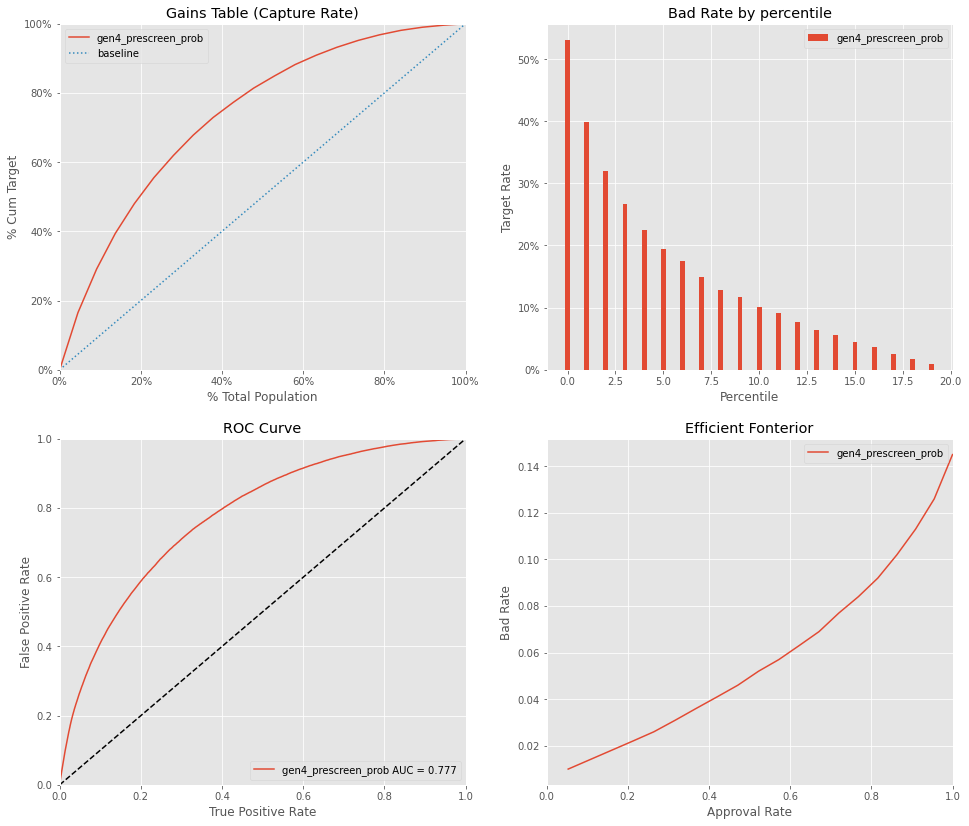

(0.7772128448398186, 41.0)

In [20]:
p_eval.model_score_eval(df[df.period!='oot18q1']['target_v2'],
                        df[df.period!='oot18q1']['gen4_prescreen_prob'],
                        Y_weight=df[df.period!='oot18q1']['weight_eval'],decile=20)

gen4_underwriting_prob AUC:  0.76303  KS:  39.0

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.4%  14308.0  0.4895  0.9403      6980.3          13.7%              2.7%       48.8%  11.0
1          8.8%  14550.0  0.3915  0.4895      5923.7          25.3%              5.8%       40.7%  19.5
2         13.4%  14805.0  0.3251  0.3915      5150.8          35.5%              9.3%       34.8%  26.2
3         18.0%  15065.0  0.2754  0.3250      4424.4          44.1%             13.2%       29.4%  30.9
4         22.7%  15306.0  0.2370  0.2754      3923.4          51.8%             17.3%       25.6%  34.5
5         27.4%  15478.0  0.2065  0.2370      3451.5          58.6%             21.7%       22.3%  36.9
6         32.2%  15669.0  0.1813  0.2065      3039.8          64.6%             26.2%       19.4%  38.4
7         37.1%  15848.0  0.1601  0.1813      2765.6          70.0%             31.0%       17.5%  

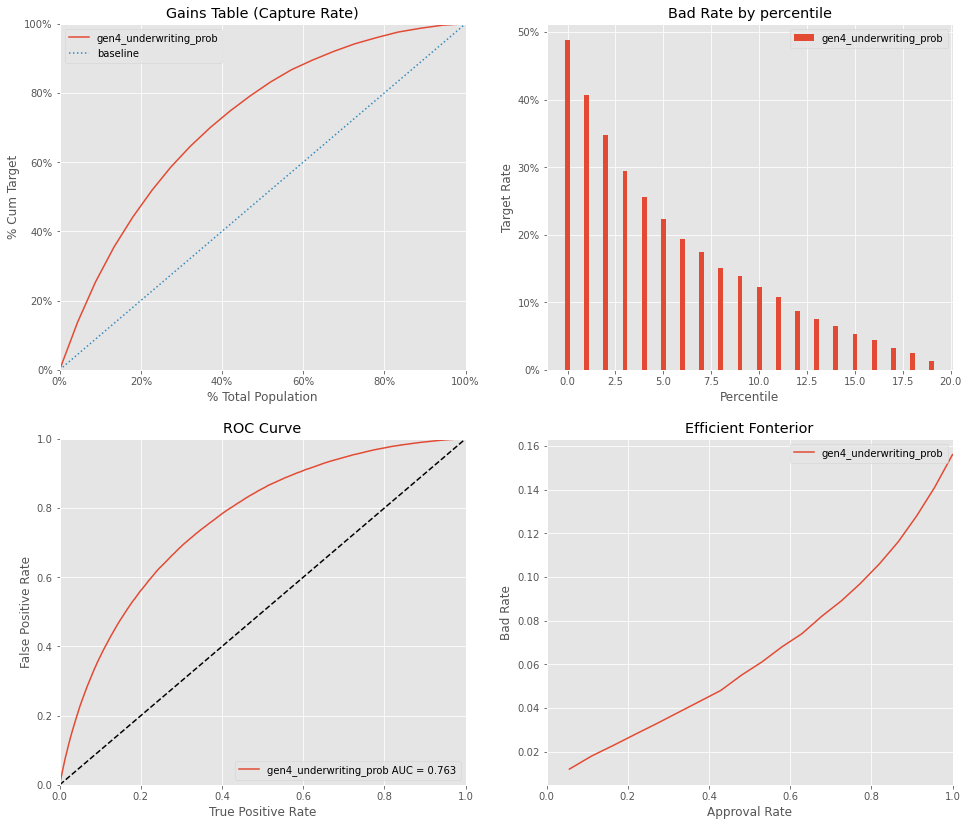

(0.7630340288624157, 38.99999999999999)

In [21]:
p_eval.model_score_eval(df[df.period=='oot18q1']['target_v2'],
                        df[df.period=='oot18q1']['gen4_underwriting_prob'],
                        Y_weight=df[df.period=='oot18q1']['weight_eval'],decile=20)

gen4_underwriting_prob AUC:  0.78264  KS:  42.1

Gains Table--Model:
   pct_cum_acct   #accts     min     max  target_num pct_cum_target pct_cum_nontarget actual_rate    KS
0          4.5%  13827.0  0.4789  0.8650      7254.2          16.3%              2.5%       52.5%  13.8
1          9.0%  13952.0  0.3794  0.4789      5751.3          29.3%              5.6%       41.2%  23.7
2         13.7%  14217.0  0.3133  0.3794      4637.5          39.7%              9.3%       32.6%  30.4
3         18.3%  14349.0  0.2644  0.3133      3921.3          48.5%             13.2%       27.3%  35.3
4         23.1%  14524.5  0.2257  0.2644      3327.8          56.0%             17.5%       22.9%  38.5
5         27.8%  14680.0  0.1941  0.2257      2945.7          62.6%             22.0%       20.1%  40.6
6         32.7%  14809.0  0.1686  0.1941      2552.9          68.4%             26.6%       17.2%  41.8
7         37.6%  15052.0  0.1471  0.1686      2336.4          73.6%             31.5%       15.5%  

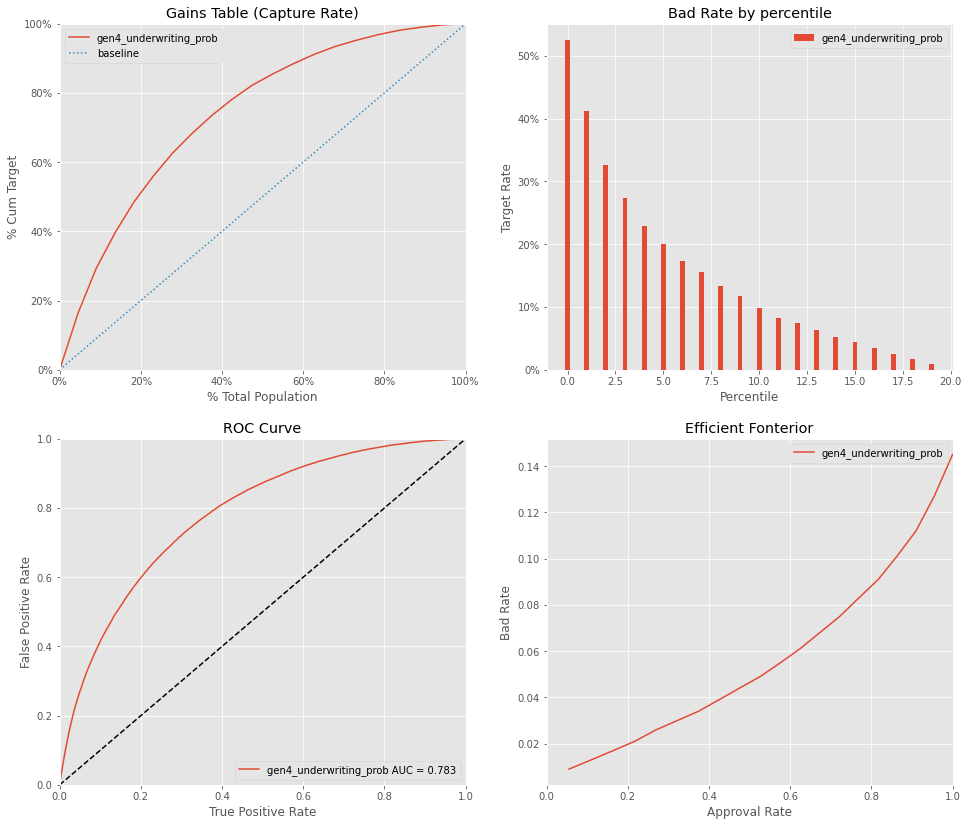

(0.7826399486136293, 42.1)

In [22]:
p_eval.model_score_eval(df[df.period!='oot18q1']['target_v2'],
                        df[df.period!='oot18q1']['gen4_underwriting_prob'],
                        Y_weight=df[df.period!='oot18q1']['weight_eval'],decile=20)